In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load Central Bank's dataset into pandas frame

In [4]:
# Path for the dataset with rates from the central bank
cb_dataset_path = 'usd_rate_2018-2019.csv'

cb_dataset = pd.read_csv(cb_dataset_path)
rates = cb_dataset['curs']

## Display given rates

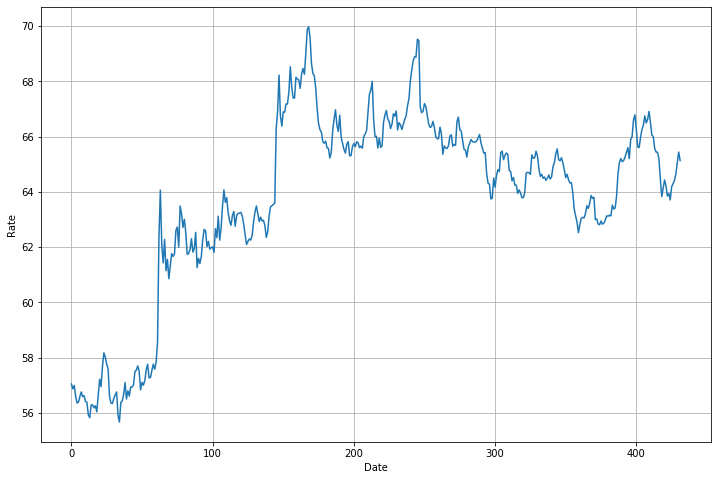

In [5]:
plt.figure(figsize=(12, 8))
plt.plot(rates)
plt.xlabel('Date')
plt.ylabel('Rate')
plt.grid(True)
plt.show()

## Prepare dataset for model

In [6]:
# Model fitting will be based on dollar's rate for last 4 weeks 
past = 7 * 4
# Model output consists of 7 rates for next 7 days
future = 7

# Determing training range
start = past
end = len(rates) - future

prepared = []
for i in range(start, end):
    past_and_future_rates = rates[ i - past : i + future ]
    prepared.append(list(past_and_future_rates))

past_columns = [f'past_{i}' for i in range(past)]
future_columns = [f'future_{i}' for i in range(future)]

prepared_rates = pd.DataFrame(prepared, columns=(past_columns + future_columns))

prepared_rates.head()

,past_0,past_1,past_2,past_3,past_4,past_5,past_6,past_7,past_8,past_9,...,past_25,past_26,past_27,future_0,future_1,future_2,future_3,future_4,future_5,future_6
0,57.0463,56.8734,56.9957,56.6019,56.3569,56.3878,56.5925,56.7597,56.5892,56.6261,...,57.7701,57.5899,56.5918,56.3554,56.3438,56.5201,56.6537,56.7608,55.9208,55.6717
1,56.8734,56.9957,56.6019,56.3569,56.3878,56.5925,56.7597,56.5892,56.6261,56.4115,...,57.5899,56.5918,56.3554,56.3438,56.5201,56.6537,56.7608,55.9208,55.6717,56.3742
2,56.9957,56.6019,56.3569,56.3878,56.5925,56.7597,56.5892,56.6261,56.4115,56.3888,...,56.5918,56.3554,56.3438,56.5201,56.6537,56.7608,55.9208,55.6717,56.3742,56.4334
3,56.6019,56.3569,56.3878,56.5925,56.7597,56.5892,56.6261,56.4115,56.3888,55.9288,...,56.3554,56.3438,56.5201,56.6537,56.7608,55.9208,55.6717,56.3742,56.4334,56.6616
4,56.3569,56.3878,56.5925,56.7597,56.5892,56.6261,56.4115,56.3888,55.9288,55.8288,...,56.3438,56.5201,56.6537,56.7608,55.9208,55.6717,56.3742,56.4334,56.6616,57.1000


## Fit models

In [199]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [8]:
import warnings; warnings.simplefilter('ignore')

In [137]:
# Initialize models
linRegModel = LinearRegression()
ridgeModel = Ridge(random_state=42)
polyModel = make_pipeline(PolynomialFeatures(degree=3), LinearRegression(fit_intercept = False))
# Try to find best multi-layer perceptron
mlpSearch = GridSearchCV(MLPRegressor(random_state=42), {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'max_iter': [10, 100, 500, 1000],
    'hidden_layer_sizes': [(150,), (30, 80), (160, 160, 160)],
    'learning_rate_init': [0.1, 0.2, 0.01, 0.001]
}, scoring='neg_mean_absolute_error')

# Define samples
X_train, y_train = prepared_rates[past_columns][:-1], prepared_rates[future_columns][:-1]
X_test, y_test = prepared_rates[past_columns][-1:], prepared_rates[future_columns][-1:]

# Fit models
linRegModel.fit(X_train, y_train)
ridgeModel.fit(X_train, y_train)
polyModel.fit(X_train, y_train)

mlpSearch.fit(X_train, y_train)
# Look at mlp search results
print(mlpSearch.best_params_, mlpSearch.best_score_, mlpSearch.best_estimator_)
mlpModel = mlpSearch.best_estimator_

{'activation': 'relu', 'hidden_layer_sizes': (150,), 'learning_rate_init': 0.001, 'max_iter': 500} -1.0230087698351427 MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(150,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=500, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=42, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)


## Display predictions for next 7 days, obtained from different models

In [207]:
# Get predictions. As our test sample has only one row from prepared_rates => we can take first result from prediction
predictions = linRegModel.predict(X_test)[0], ridgeModel.predict(X_test)[0], polyModel.predict(X_test)[0], mlpModel.predict(X_test)[0]
predictions = np.array(predictions)

model_types = ('Linear Regression', 'Ridge Regression', 'Polynomial Regression', 'Multi-layer Perceptron Regression')
predictions_df = pd.DataFrame(predictions, columns=future_columns, index=model_types)

predictions_df

,future_0,future_1,future_2,future_3,future_4,future_5,future_6
Linear Regression,64.164120,64.259965,64.251490,64.157810,64.171478,64.274809,64.415721
Ridge Regression,64.157303,64.253903,64.246066,64.153614,64.167041,64.270721,64.410972
Polynomial Regression,64.958782,62.706872,63.197104,61.129155,59.980047,61.037809,62.889141
Multi-layer Perceptron Regression,65.600089,66.900146,65.726586,66.371241,65.038290,65.519950,66.010150


## Caculate errors for each model

In [204]:
errors = []

for pred in predictions:
    norm_error = np.linalg.norm(y_test - pred)
    mae = mean_absolute_error(y_test.iloc[0], pred)
    
    errors.append([norm_error, mae])

## Display errors/regressions table

In [206]:
errors_df = pd.DataFrame(errors, columns=('norm_error', 'mae'), index=model_types)

errors_df

,norm_error,mae
Linear Regression,1.476374,0.444497
Ridge Regression,1.481782,0.445927
Polynomial Regression,7.759903,2.621708
Multi-layer Perceptron Regression,4.186561,1.345879


## Results

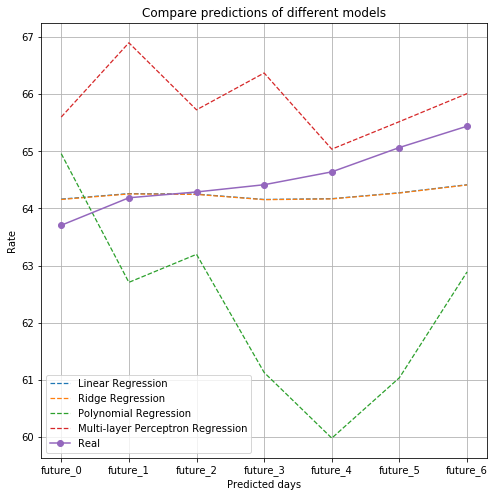

In [215]:
plt.figure(figsize=(8, 8))
plt.title("Compare predictions of different models")
for i, model in enumerate(model_types):
    plt.plot(predictions[i], label=model, linestyle='--', linewidth=1.25)
plt.plot(y_test.iloc[0], label='Real', marker='o')
plt.xlabel('Predicted days')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)